In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 200

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

In [6]:
# Read raw data
df_raw = pd.read_csv('dataframe.csv')

# Prepare columns
df_raw.dropna(inplace=True)
change_labels = lambda x: 1 if x=='good' else 0
df_raw['class_mark'] = df_raw['class_mark'].apply(change_labels)

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text_review.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text_review'] = df_raw['text_review'].apply(trim_string)



# Split according to label
df_good = df_raw[df_raw['class_mark'] == 1]
df_bad = df_raw[df_raw['class_mark'] == 0]

# Train-test split
df_good_full_train,df_good_train  = train_test_split(df_good, train_size = train_test_ratio, random_state = 1)
df_bad_full_train,df_bad_train  = train_test_split(df_bad, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_good_test, df_good_valid = train_test_split(df_good_full_train, train_size = train_valid_ratio, random_state = 1)
df_bad_test, df_bad_valid = train_test_split(df_bad_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_good_train, df_bad_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_good_valid, df_bad_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_good_test, df_bad_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv('train.csv', index=False)
df_valid.to_csv('valid.csv', index=False)
df_test.to_csv('test.csv', index=False)

df_raw.head()

,class_mark,text_review
0,1,Зеленая миля 'Они помогли ему убить себя и так...
1,1,"Зеленая миля 'Боже, иногда Зеленая миля так дл..."
2,1,Зеленая миля Они помогли ему убить себя «Они п...
3,1,Зеленая миля «Когда призовет Господь на свой с...
4,1,Зеленая миля Обвиненный в страшном преступлени...


In [9]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

import spacy

In [16]:
nlp = spacy.load("en_core_web_sm")

In [35]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize=nlp,  include_lengths=True, batch_first=True)
fields = [('class_mark', label_field), ('text_review', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='./',train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text_review),
                             sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text_review),
                             sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text_review),
                             sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [36]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [37]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [38]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = './',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (class_mark,  (text_review, text_len)), _ in train_loader:           
            class_mark = class_mark.to()
            text_review = text_review.to()
            text_len = text_len.to()
            output = model(text_review, text_len)

            loss = criterion(output, class_mark)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (class_mark,  (text_review, text_len)), _ in valid_loader:
                      class_mark = class_mark.to()
                      text_review = text_review.to()
                      text_len = text_len.to()
                      output = model(text_review, text_len)

                      loss = criterion(output, class_mark)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [28/570], Train Loss: 0.6958, Valid Loss: 0.7373
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [1/10], Step [56/570], Train Loss: 0.6828, Valid Loss: 0.7352
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/10], Step [84/570], Train Loss: 0.7267, Valid Loss: 0.7691
Epoch [2/10], Step [112/570], Train Loss: 0.7034, Valid Loss: 0.6942
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [3/10], Step [140/570], Train Loss: 0.7309, Valid Loss: 0.6945
Epoch [3/10], Step [168/570], Train Loss: 0.7077, Valid Loss: 0.6923
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [4/10], Step [196/570], Train Loss: 0.7072, Valid Loss: 0.6915
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [4/10], Step [224/570], Train Loss: 0.6981, Valid Loss: 0.6923
Epoch [5/10], Step [252/570], Train Loss: 0.7073, Valid Loss: 0.6907
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.p

KeyboardInterrupt: 

Model loaded from <== metrics.pt


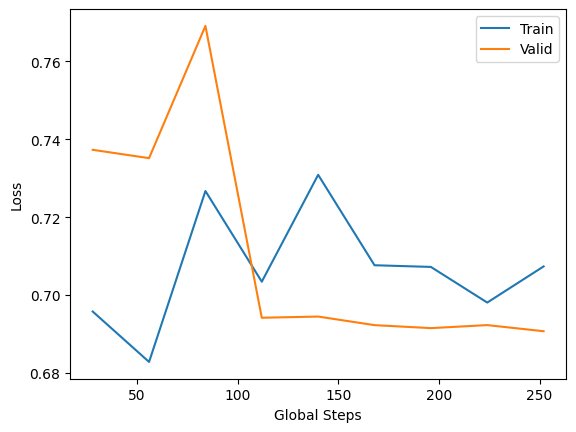

In [41]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics( 'metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [51]:
# Evaluation Function

def evaluate(model, test_loader, version='text_review', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (class_mark, (text_review, text_len)), _ in test_loader:           
            class_mark = class_mark.to()
            text_review = text_review.to()
            text_len = text_len.to()
            output = model(text_review, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(class_mark.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, class_mark=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, class_mark=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['bad', 'good'])
    ax.yaxis.set_ticklabels(['bad', 'good'])
    
    
best_model = LSTM().to()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Model loaded from <== model.pt
Classification Report:


TypeError: classification_report() got an unexpected keyword argument 'class_mark'